In [1]:
import pandas as pd

In [2]:
basket=pd.read_csv('/content/VendaNotaFiscalClienteProduto_Abr2017_Abr2021_AF.csv',sep=';')
basket.sort_values(by='NotaFiscal')
groceries=basket[['NotaFiscal','NomeProduto']].sort_values(by='NotaFiscal')
groceries

,NotaFiscal,NomeProduto
248652,1,OCULOS RAY BAN 3546 907151 52
240101,1,PRODUTO TESTE NFCe
248653,2,OCULOS RAY BAN 3546 907151 52
248654,3,OCULOS RAY BAN 3546 907151 52
240102,3,PRODUTO TESTE NFCe
...,...,...
72319,33808,LT VS ORMA CRIZAL PREVENCIA SURFACADA
72320,33808,LT VS Orma CRIZAL EASY UV
72321,33808,ARMACAO ATITUDE 6025 T01
107556,102003700,LT ACAB. ORMA CRIZAL FORTE


In [3]:
nulos = groceries.isnull().sum()
nulos

NotaFiscal     0
NomeProduto    0
dtype: int64

In [4]:
groceries = groceries.groupby(['NotaFiscal'])['NomeProduto'].apply(lambda x: ','.join(x)).reset_index()
groceries

,NotaFiscal,NomeProduto
0,1,"OCULOS RAY BAN 3546 907151 52,PRODUTO TESTE NFCe"
1,2,OCULOS RAY BAN 3546 907151 52
2,3,"OCULOS RAY BAN 3546 907151 52,PRODUTO TESTE NFCe"
3,4,"OCULOS CARRERA 1001S 80S 629O,OCULOS RAY BAN 4..."
4,5,"OCULOS CARRERA 155S 003 62UC,KIT AJUSTE COM PA..."
...,...,...
33415,33805,"MIOLIGHT/ HIPERLIGHT 1.67 DG HARD,ARMACAO JOLI..."
33416,33806,"PROG DIGITAL LIGHT HD 1.5,ARMACAO ARNETTE 7175..."
33417,33807,"COLORACAO CINZA DEGRADE 3,LT HI VISION 1.50 SU..."
33418,33808,OCULOS EMPORIO ARMANI 4115 50421W 54 COM DOIS ...


In [ ]:

# get all the transcactions as a list
transactions = list(groceries['NomeProduto'].apply(lambda x: sorted(x.split(','))))
transactions

As you can see the items are in the same row, separated by a comma. There are two ways to create the onehot data frame. One is to work with the CountVectorizer as explained in another post or to work with the TransactionEncoder as we will show right now. For this example, we will work with association rules of 3 items.

In [7]:
# instantiate transcation encoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori


encoder = TransactionEncoder().fit(transactions)
onehot = encoder.transform(transactions)

# convert one-hot encode data to DataFrame
onehot = pd.DataFrame(onehot, columns=encoder.columns_)

# compute frequent items using the Apriori algorithm - Get up to three items
frequent_itemsets = apriori(onehot, min_support = 0.001, max_len = 3, use_colnames=True)

# compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(COLORACAO PROXIMO DA AMOSTRA),( LENTE HI VISION POLARIZADA CINZA),0.135069,0.007959,0.001646,0.012184,1.530826,0.000571,1.004277
1,( LENTE HI VISION POLARIZADA CINZA),(COLORACAO PROXIMO DA AMOSTRA),0.007959,0.135069,0.001646,0.206767,1.530826,0.000571,1.090387
2,(LT ACAB. POLY AR),( LENTE HI VISION POLARIZADA CINZA),0.088929,0.007959,0.001167,0.013122,1.648696,0.000459,1.005232
3,( LENTE HI VISION POLARIZADA CINZA),(LT ACAB. POLY AR),0.007959,0.088929,0.001167,0.146617,1.648696,0.000459,1.067599
4,(LT HI VISION 1. 50 AR),( LENTE HI VISION POLARIZADA CINZA),0.147756,0.007959,0.001526,0.010328,1.297609,0.000350,1.002393
...,...,...,...,...,...,...,...,...,...
18615,"(VARILUX COMFORT ORMA CRIZAL EASY, VS POLY IN...",(VARILUX COMFORT ORMA),0.003441,0.035667,0.001376,0.400000,11.214765,0.001254,1.607221
18616,"(VARILUX COMFORT ORMA, VS POLY INCOLOR (LENTE...",(VARILUX COMFORT ORMA CRIZAL EASY),0.003710,0.031388,0.001376,0.370968,11.818629,0.001260,1.539844
18617,(VARILUX COMFORT ORMA CRIZAL EASY),"(VARILUX COMFORT ORMA, VS POLY INCOLOR (LENTE...",0.031388,0.003710,0.001376,0.043851,11.818629,0.001260,1.041982
18618,(VARILUX COMFORT ORMA),"(VARILUX COMFORT ORMA CRIZAL EASY, VS POLY IN...",0.035667,0.003441,0.001376,0.038591,11.214765,0.001254,1.036560


Let’s say that we want to get the top associated rules, given that the left-hand side has two items, then which item is more likely to be added to the basket?

In [10]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs items,antecedents_,consequents_
16349,"(PROG HI VISION CR-39, TRATAMENTO AR DURAVISIO...",(PR ZEISS CLASSIC 1.50),0.006463,0.007540,0.001017,0.157407,20.875220,0.000969,1.177864,2,"PROG HI VISION CR-39,TRATAMENTO AR DURAVISION ...",PR ZEISS CLASSIC 1.50
16373,"(TRATAMENTO LIGHT GREEN, TRATAMENTO AR DURAVIS...",(PR ZEISS CLASSIC 1.50),0.013315,0.007540,0.001975,0.148315,19.669342,0.001874,1.165289,2,"TRATAMENTO LIGHT GREEN,TRATAMENTO AR DURAVISIO...",PR ZEISS CLASSIC 1.50
7350,"(VARILUX CONFORT 360° ORMA CRIZAL EASY, COLORA...",(VX CONFORT 360° ORMA),0.003770,0.019330,0.001406,0.373016,19.297508,0.001333,1.564107,2,"VARILUX CONFORT 360° ORMA CRIZAL EASY,COLORACA...",VX CONFORT 360° ORMA
7344,"(VARILUX CONFORT 360° ORMA CRIZAL EASY, COLORA...",(VX COMFORT 360° ORMA VERNIZ HC),0.003770,0.016158,0.001137,0.301587,18.664903,0.001076,1.408683,2,"VARILUX CONFORT 360° ORMA CRIZAL EASY,COLORACA...",VX COMFORT 360° ORMA VERNIZ HC
9773,"(COLORACAO PROXIMO DA AMOSTRA, VARILUX CONFORT...",(VX COMFORT 360° ORMA VERNIZ HC),0.010892,0.016158,0.003202,0.293956,18.192613,0.003026,1.393457,2,"COLORACAO PROXIMO DA AMOSTRA,VARILUX CONFORT 3...",VX COMFORT 360° ORMA VERNIZ HC
9730,"(COLORACAO PROXIMO DA AMOSTRA, VARILUX COMFORT...",(VARILUX COMFORT ORMA),0.010353,0.035667,0.006703,0.647399,18.151065,0.006333,2.734911,2,"COLORACAO PROXIMO DA AMOSTRA,VARILUX COMFORT O...",VARILUX COMFORT ORMA
16372,"(TRATAMENTO LIGHT GREEN, PR ZEISS CLASSIC 1.50)",(TRATAMENTO AR DURAVISION CHROME),0.003232,0.034231,0.001975,0.611111,17.852564,0.001864,2.483406,2,"TRATAMENTO LIGHT GREEN,PR ZEISS CLASSIC 1.50",TRATAMENTO AR DURAVISION CHROME
9779,"(COLORACAO PROXIMO DA AMOSTRA, VARILUX CONFORT...",(VX CONFORT 360° ORMA),0.010892,0.019330,0.003740,0.343407,17.765710,0.003530,1.493573,2,"COLORACAO PROXIMO DA AMOSTRA,VARILUX CONFORT 3...",VX CONFORT 360° ORMA
16336,"(LT ZEISS PROGRESSIVE LIGHT D 1.5 (freeform), ...",(TRATAMENTO AR DURAVISION CHROME),0.001885,0.034231,0.001137,0.603175,17.620713,0.001073,2.433738,2,"LT ZEISS PROGRESSIVE LIGHT D 1.5 (freeform),TR...",TRATAMENTO AR DURAVISION CHROME
8837,"(COLORACAO PROXIMO DA AMOSTRA, TRATAMENTO AR D...",(PR ZEISS CLASSIC 1.50),0.008618,0.007540,0.001137,0.131944,17.498347,0.001072,1.143313,2,"COLORACAO PROXIMO DA AMOSTRA,TRATAMENTO AR DUR...",PR ZEISS CLASSIC 1.50


As we can see, if someone has already added to his basket (coffee, biscuit) or (cereal, biscuit) then the item which is more likely to be added is orange

#Visualize Market Basket Analysis
Now, we will show how we can visualize the Market Basket Analysis Association Rules using Heatmap. We will show all the rules where the left-hand side consists of 2 items and we are looking for an extra one.

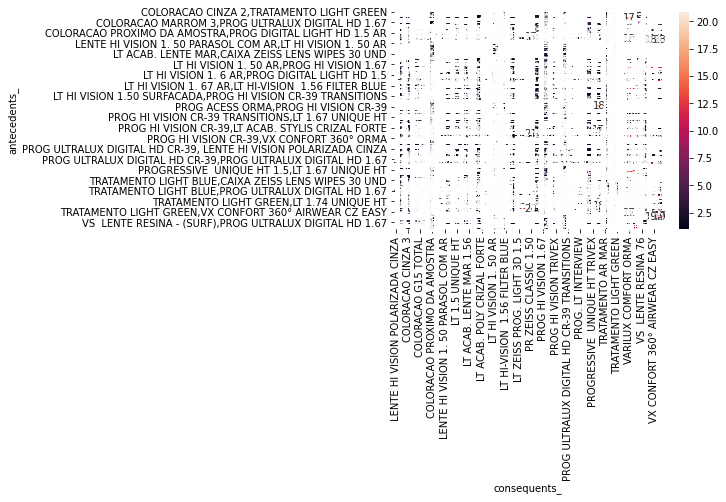

In [9]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()